In [1]:
import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, join
import astropy.units as u

import scipy.stats as stats

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 24,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

## GAMA catalog details

In [ ]:
#download GAMA from the database
with fits.open('http://www.gama-survey.org/dr4/data/cat/gkvInputCat/v02/gkvInputCatv02.fits') as cat:
    gkvInputCat = Table(cat[1].data)

with fits.open('http://www.gama-survey.org/dr4/data/cat/StellarMasses/v24/StellarMassesGKVv24.fits') as cat:
    StellarMassesGKV = Table(cat[1].data)

GAMA_mstar_concat = join(gkvInputCat, StellarMassesGKV)

In [285]:
#OR, if the joined catalog exists, import GAMA:
with fits.open('/data2/lsajkov/mpdg/data/GAMA/GAMA_mstars_concat.fits') as hdu:
    GAMA_mstar_concat = Table(hdu[1].data)

Redshifts

In [118]:
#redshift distribution
redshifts = GAMA_mstar_concat[~np.isnan(GAMA_mstar_concat['Z']) &\
                                       (GAMA_mstar_concat['Z'] >= 0)]['Z']

print('= GAMA redshifts =')
print('counting non-nan ')
print('and >= 0 only')
print(f'total:\t{len(redshifts)}')
print(f'min:\t{np.min(redshifts):.3f}')
print(f'max:\t{np.max(redshifts):.3f}')
print(f'mean:\t{np.mean(redshifts):.3f}')
print(f'median:\t{np.median(redshifts):.3f}')
print(f'std:\t{np.std(redshifts):.3f}')
print('==================')

= GAMA redshifts =
counting non-nan 
and >= 0 only
total:	364119
min:	0.000
max:	7.023
mean:	0.264
median:	0.219
std:	0.291


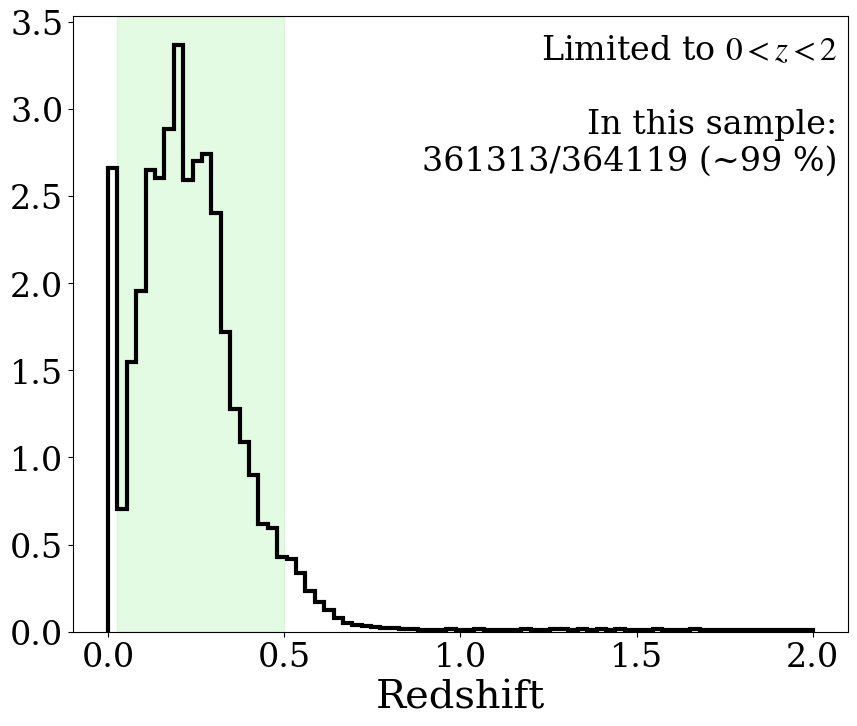

In [119]:
fig = plt.figure(figsize = (10, 8))
ax  = fig.add_subplot()

GAMA_redshift_subset = redshifts[(redshifts >= 0.) &\
                       (redshifts < 2)]

ax.hist(GAMA_redshift_subset,
        bins = 75, histtype = 'step',
        linewidth = 3, color = 'black', density = True)

ax.set_xlabel('Redshift')
ax.text(0.45, 0.75,
        f'Limited to $0 < z < 2$\n\nIn this sample:\n{len(GAMA_redshift_subset)}/{len(GAMA_redshifts)} (~{int(100 * len(GAMA_redshift_subset)/len(GAMA_redshifts))} %)',
        transform = ax.transAxes,
        ma = 'right')

ax.axvspan(0.025, 0.5, color = 'lightgreen', alpha = 0.25)

Magnitude distribution

In [144]:
g_snr = GAMA_mstar_concat['flux_gt']/GAMA_mstar_concat['flux_err_gt']
g_mag = GAMA_mstar_concat['flux_gt'] * u.Jy
g_mag = g_mag.to(u.ABmag).value

r_snr = GAMA_mstar_concat['flux_rt']/GAMA_mstar_concat['flux_err_rt']
r_mag = GAMA_mstar_concat['flux_rt'] * u.Jy
r_mag = r_mag.to(u.ABmag).value

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/var/tmp/lsajkov/ipykernel_1193969/3428203710.py:3: RuntimeWarning: divide by zero encountered in divide
  g_snr = GAMA_mstar_concat['flux_gt']/GAMA_mstar_concat['flux_err_gt']


Text(0.5, 0, 'Magnitude ($r$ or $g$)')

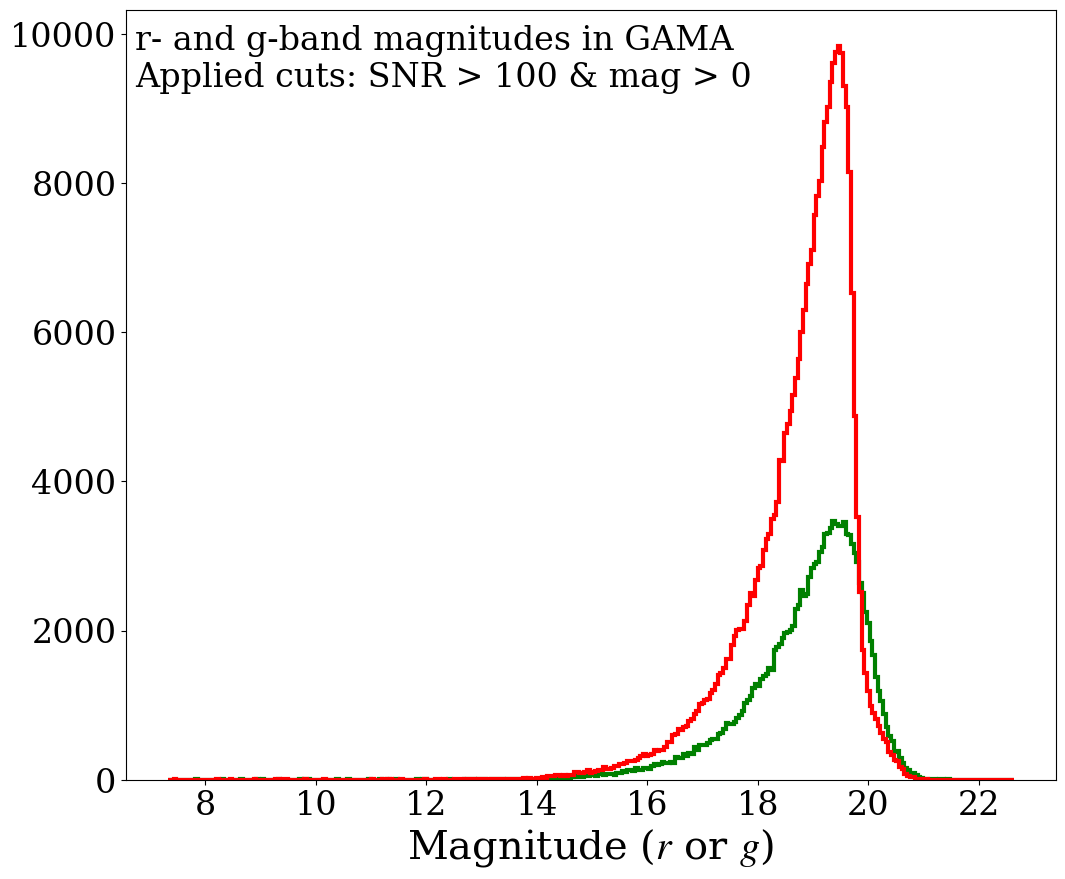

In [168]:
fig = plt.figure(figsize = (12, 10))
ax  = fig.add_subplot()

snr_thresh = 100

bins = ax.hist(g_mag[(g_mag > 0) & (g_snr > snr_thresh)],
        bins = 'auto',
        histtype = 'step', color = 'green',
        linewidth = 3)
ax.hist(r_mag[(r_mag > 0) & (r_snr > snr_thresh)],
        bins = bins[1], 
        histtype = 'step', color = 'red',
        linewidth = 3)

ax.text(0.01, 0.9,
        f'r- and g-band magnitudes in GAMA\nApplied cuts: SNR > {snr_thresh} & mag > 0',
        transform = ax.transAxes)

ax.set_xlabel('Magnitude ($r$ or $g$)')

R-band effective fwhm radius

In [276]:
#the approximate area defined by the fwhm is 76%
#the area within R50 is 50%
#therefore, to scale R50 up to Rfwhm, we must scale up by
r50_to_fwhm_scale_factor = np.sqrt(0.76/0.50)

In [277]:
r50_to_fwhm_scale_factor

1.2328828005937953

In [2]:
def gaussian(x, mean, std):
    return 1 / (np.sqrt(2 * np.pi * std**2)) * np.exp(-(x - mean) ** 2/(2 * std ** 2))

In [283]:
std = 1

xs, ys = np.meshgrid(np.linspace(-3, 3, 501),
                    np.linspace(-3, 3, 501))
gauss2d = gaussian(xs, 0, std) * gaussian(ys, 0, std)
gauss2d /= np.sum(gauss2d)

fwhm_idx  = np.abs(gauss2d - np.max(gauss2d)/2) < 1e-3
fwhm_ring = np.where(fwhm_idx, True, np.nan)
fwhm_radius_x = (np.max(xs[fwhm_idx]) - np.min(xs[fwhm_idx])) / 2
fwhm_radius_y = (np.max(ys[fwhm_idx]) - np.min(ys[fwhm_idx])) / 2
fwhm_area = np.where(gauss2d > np.max(gauss2d)/2,
                    True, np.nan) 

thresh = np.max(gauss2d) * 0.95
while np.sum(gauss2d[gauss2d > thresh]) < 0.5:
    thresh -= 1e-7
half_light_idx  = gauss2d > thresh
half_light_radius_x = (np.max(xs[half_light_idx]) - np.min(xs[half_light_idx])) / 2
half_light_radius_y = (np.max(ys[half_light_idx]) - np.min(ys[half_light_idx])) / 2
half_light_ring = np.where(gauss2d > thresh, True, np.nan)

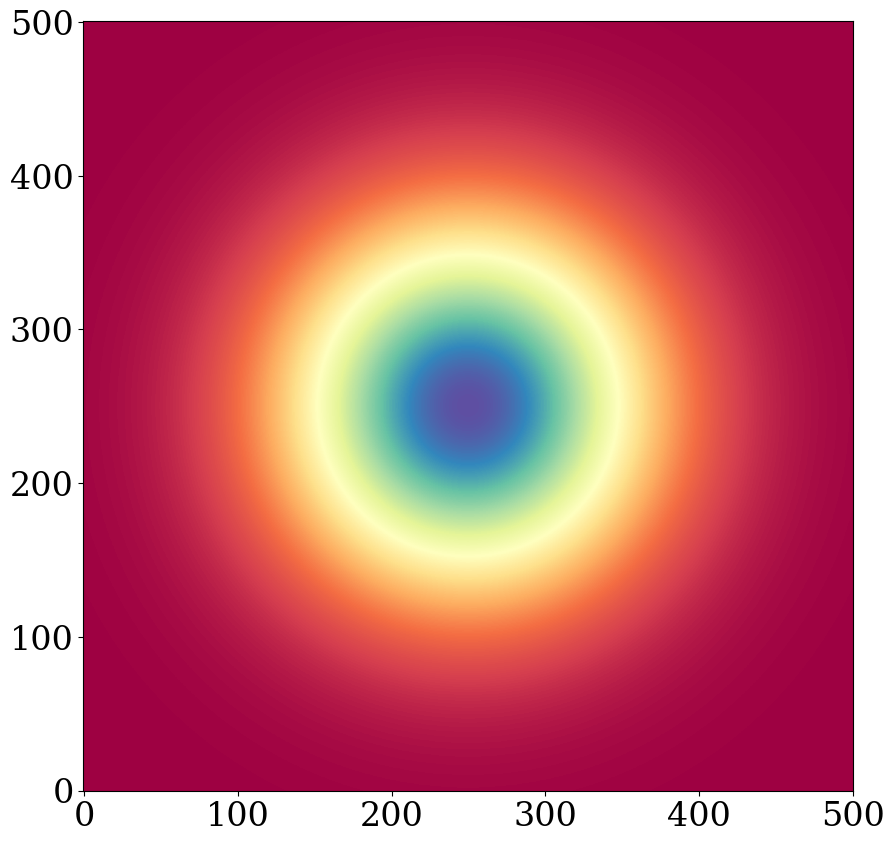

In [284]:
fig = plt.figure(figsize = (10, 10))
ax  = fig.add_subplot()

ax.imshow(gauss2d, origin = 'lower', cmap = 'Spectral')

In [280]:
fwhm_radius_x/r50_to_fwhm_scale_factor

1.8493242008906938

In [281]:
half_light_radius_x

1.08

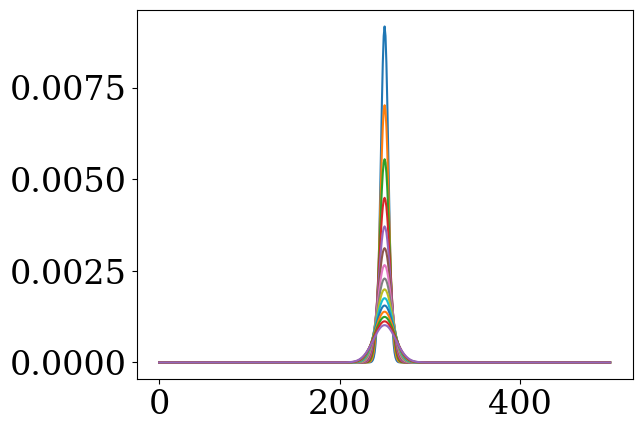

In [273]:
half_light_radii = []
fwhm_radii = []

for std in np.linspace(0.5, 1.5, 15):
    xs, ys = np.meshgrid(np.linspace(-30, 30, 501),
                        np.linspace(-30, 30, 501))
    gauss2d = gaussian(xs, 0, std) * gaussian(ys, 0, std)
    gauss2d /= np.sum(gauss2d)

    fwhm_idx  = np.abs(gauss2d - np.max(gauss2d)/2) < 1e-3
    # fwhm_ring = np.where(fwhm_idx, True, np.nan)
    fwhm_radius_x = (np.max(xs[fwhm_idx]) - np.min(xs[fwhm_idx])) / 2
    # fwhm_radius_y = (np.max(ys[fwhm_idx]) - np.min(ys[fwhm_idx])) / 2
    # fwhm_area = np.where(gauss2d > np.max(gauss2d)/2,
    #                     True, np.nan) 

    thresh = np.max(gauss2d) * 0.95
    while np.sum(gauss2d[gauss2d > thresh]) < 0.5:
        thresh -= 1e-7
    half_light_idx  = gauss2d > thresh
    half_light_radius_x = (np.max(xs[half_light_idx]) - np.min(xs[half_light_idx])) / 2
    # half_light_radius_y = (np.max(ys[half_light_idx]) - np.min(ys[half_light_idx])) / 2
    # half_light_ring = np.where(gauss2d > thresh, True, np.nan)

    half_light_radii.append(half_lighthttp://desi.ibl.gov/_radius_x)
    fwhm_radii.append(fwhm_radius_x)
    
    plt.plot(gauss2d[250])

half_light_radii = np.array(half_light_radii)
fwhm_radii = np.array(fwhm_radii)

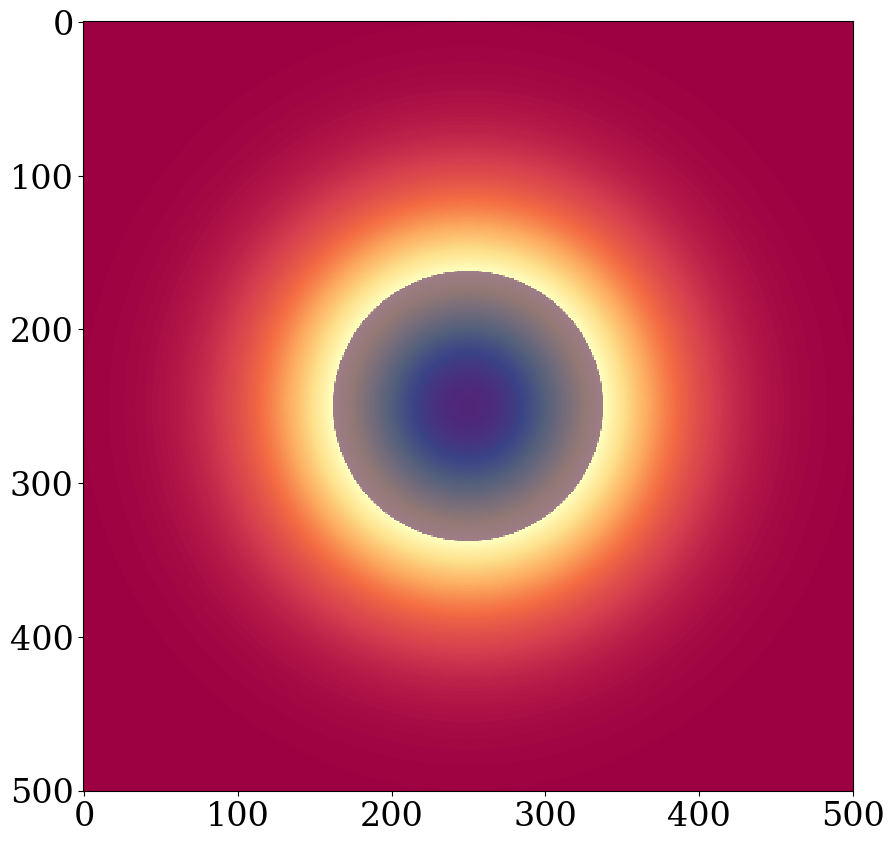

In [250]:
fig = plt.figure(figsize = (10, 10))
ax  = fig.add_subplot()

ax.imshow(gauss2d, origin = 'lower', cmap = 'Spectral')

# ax.imshow(fwhm_ring, origin = 'lower')

# thresh = np.max(gauss2d) * 0.95
# while np.sum(gauss2d[gauss2d > thresh]) < 0.5:
#     thresh -= 1e-7
# half_light_ring = np.where(gauss2d > thresh, True, np.nan)

# ax.imshow(half_light_ring, cmap = 'viridis', alpha = 0.3)
# ax.imshow(fwhm_area, cmap = 'viridis', alpha = 0.3)

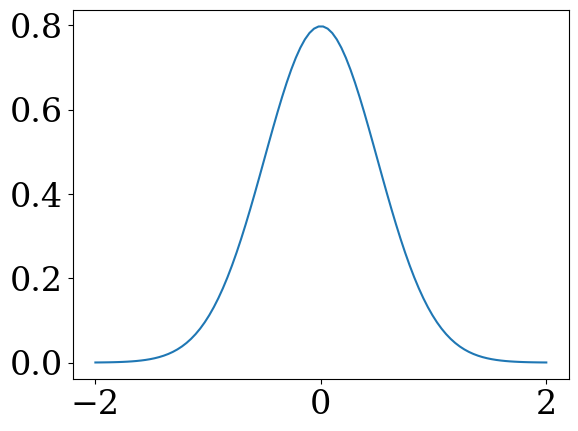

In [5]:
plt.plot(np.linspace(-2, 2, 100),
         gaussian(np.linspace(-2, 2, 100), 0, 0.5))